In [20]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
import csv
import re
from nltk import corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
# get data in notebook
mbti = pd.read_csv(r"C:\Users\tonym\Documents\Flatiron\phase_5\capstone\MBTI-ML-Social-Media-\data\mbti_1.csv")

In [6]:
# check top and bottom of data set 
mbti.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [7]:
mbti.tail()

,type,posts
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...
8674,INFP,'It has been too long since I have been on per...


In [9]:
# 
mbti.shape

(8675, 2)

Over 8500 rows. Posts and type appear to be the only columns.

In [8]:
# check for null values in the set 
mbti.isnull().sum()

type     0
posts    0
dtype: int64

In [18]:
mbti.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'INTP female. Most: ENTJ, ESTJ, ENFJ Least: I..."
freq,1832,1


no null values 

In [10]:
mbti.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [11]:
# checking how many records there are for each personality type 
mbti['type'].value_counts()

INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: type, dtype: int64

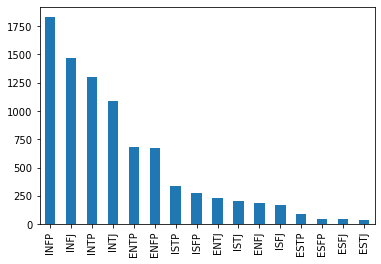

In [17]:
# showing type counts as visulaization 
mbti['type'].value_counts().plot(kind = 'bar')
plt.show()

Looks like INFP, INFJ, INTP are the most popular. Other types are much lower. Dataset is pretty unbalanced.


Deciding on how to deal with data imbalance. Different ways to do this could be: 
- Oversampling
- Downsampling
- SMOTE
- Near Miss
- gather more data 

 In order to handle the imbalance a good way we can convert the 16 classes into 4 classes. These new 4 classes will be more balanced. This will also make help the machine learning models classify the text as there are less classes to work with